In [44]:
import os
import random
import shutil
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
from semantic_transforms import (
    FFTSuppressAmplitude,
    GaussianBlur,
    CannyEdge,
    EdgeMaskedBlur,
    GrayScale,
    ColorSwap,
    RandomDropChannel,
    MyColorJitter,
    HistEqualization,
    RandomChannelNormalization,
    LowFrequencyNoiseInjection
)

In [45]:
seed = 123
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [46]:
dataset_paths = {
    "PACS" : os.path.join(os.getcwd(), "PACS", "kfold")
    }

### Dataset Class

In [47]:
class DGDomainDataset(Dataset):
    def __init__(self, root, seed=seed, train=True, transform=None):
        random.seed(seed)

        self.root = root
        self.transform = transform
        train_path_list = []
        validation_path_list = []
        self.domain_to_idx = {}

        # Traverse directory structure
        domains = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
        for domain_idx, domain in enumerate(domains):
            self.domain_to_idx[domain] = domain_idx
            domain_path = os.path.join(root, domain)

            classes = sorted([c for c in os.listdir(domain_path) if os.path.isdir(os.path.join(domain_path, c))])
            for cls in classes:
                class_path = os.path.join(domain_path, cls)
                img_filenames = [
                    f for f in os.listdir(class_path)
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
                ]
                train_val_split = int(len(img_filenames) * 0.85)
                train_img_filenames = img_filenames[:train_val_split]
                validation_img_filenames = img_filenames[train_val_split:]
                for img in train_img_filenames:
                    train_path_list.append({
                        "path": os.path.join(class_path, img),
                        "domain": domain,
                        "class": cls
                    })
                for img in validation_img_filenames:
                    validation_path_list.append({
                        "path": os.path.join(class_path, img),
                        "domain": domain,
                        "class": cls
                    })

        random.shuffle(train_path_list)
        random.shuffle(validation_path_list)
        if train:
            self.path_list = train_path_list
        else:
            self.path_list = validation_path_list

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        sample = self.path_list[idx]
        img_path = sample["path"]
        domain = sample["domain"]
        domain_idx = self.domain_to_idx[domain]

        image = Image.open(img_path).convert('RGB')
        
        # Apply transform if provided (this includes ToTensor and normalization)
        if self.transform:
            image = self.transform(image)
        else:
            # If no transform, just convert to tensor
            image = transforms.ToTensor()(image)

        return image, domain_idx


In [48]:
def get_transform(**kwargs):
    title = ''
    if "fourier" in kwargs.keys():
        for k, v in kwargs.items():
            title += str(k)
            title += ' = '+str(v) if v is not None else ''
            title += ' '
            if k == "ampl_scale":
                ampl_scale = v
        tr = FFTSuppressAmplitude(ampl_scale=ampl_scale)
    elif "blur" in kwargs.keys():
        for k, v in kwargs.items():
            title += str(k)
            title += ' = '+str(v) if v is not None else ''
            title += ' '
            if k == "blur_scale":
                blur_scale = v
        tr = GaussianBlur(blur_scale=blur_scale)
    elif "edge" in kwargs.keys():
        for k, v in kwargs.items():
            title += str(k)
            title += ' = '+str(v) if v is not None else ''
            title += ' '
            if k == "edge_scale":
                edge_scale = v
        tr = CannyEdge(edge_scale=edge_scale)
    elif "edgeMaskedBlur" in kwargs.keys():
        for k, v in kwargs.items():
            title += ' = '+str(k)
            title += ' '
            title += str(v) if v is not None else ''
            if k == "blur_scale":
                blur_scale = v
            elif k == "edge_scale":
                edge_scale = v
        tr = EdgeMaskedBlur(blur_scale=blur_scale, edge_scale=edge_scale)
    elif "gray" in kwargs.keys():
        for k, v in kwargs.items():
            title += str(k)
            title += ' = '+str(v) if v is not None else ''
            title += ' '
        tr = GrayScale()
    elif "colorSwap" in kwargs.keys():
        for k, v in kwargs.items():
            title += str(k)
            title += ' = '+str(v) if v is not None else ''
            title += ' '
            if k == "seed":
                seed =v
        tr = ColorSwap(seed=seed)
    elif "colorDrop" in kwargs.keys():
        for k, v in kwargs.items():
            title += str(k)
            title += ' = '+str(v) if v is not None else ''
            title += ' '
            if k == "drop_rate":
                drop_rate = v
            elif k == "seed":
                seed = v
        tr = RandomDropChannel(drop_rate=drop_rate, seed=seed)
    elif "colorJitter" in kwargs.keys():
        for k, v in kwargs.items():
            title += str(k)
            title += ' = '+str(v) if v is not None else ''
            title += ' '
            if k == "brightness":
                brightness = v
            elif k == "contrast":
                contrast = v
            elif k == "saturation":
                saturation = v
            elif k == "hue":
                hue = v
            elif k == "seed":
                seed = v
        tr = MyColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue, seed=seed)
    elif "histEqualize" in kwargs.keys():
        for k, v in kwargs.items():
            title += str(k)
            title += ' = '+str(v) if v is not None else ''
            title += ' '
            if k == "clip_limit":
                clip_limit = v
            elif k == "tile_grid_size":
                tile_grid_size = v
        tr = HistEqualization(clip_limit=clip_limit, tile_grid_size=tile_grid_size)
    elif "rndChannelNormalize" in kwargs.keys():
        for k, v in kwargs.items():
            title += str(k)
            title += ' = '+str(v) if v is not None else ''
            title += ' '
            if k == "mean_shift_range":
                mean_shift_range = v
            elif k == "scale_range":
                scale_range = v
            elif k == "seed":
                seed = v
        tr = RandomChannelNormalization(mean_shift_range=mean_shift_range, scale_range=scale_range, seed=seed)
    elif "lowFreqNoiseInject" in kwargs.keys():
        for k, v in kwargs.items():
            title += str(k)
            title += ' = '+str(v) if v is not None else ''
            title += ' '
            title+=' '
            if k == "alpha":
                alpha = v
            elif k == "blur_kernel":
                blur_kernel = v
            elif k == "seed":
                seed = v
        tr = LowFrequencyNoiseInjection(alpha=alpha, blur_kernel=blur_kernel, seed=seed)
    
    
    return tr, title

In [49]:
# Transform list of kwargs
tr_list = [get_transform(fourier=None, ampl_scale=0), 
           get_transform(fourier=None, ampl_scale=0.5),
           get_transform(blur=None, blur_scale=10),
           get_transform(blur=None, blur_scale=50),
           get_transform(edge=None, edge_scale=100),
           get_transform(edgeMaskedBlur=None, blur_scale=50, edge_scale=100),
           get_transform(edgeMaskedBlur=None, blur_scale=50, edge_scale=250),
           get_transform(gray=None),
           get_transform(colorSwap=None, seed=123),
           get_transform(colorSwap=None, seed=1234),
           get_transform(colorDrop=None, drop_rate=1, seed=123),
           get_transform(colorDrop=None, drop_rate=0.5, seed=123),
           get_transform(colorJitter=None, brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3, seed=123),
           get_transform(colorJitter=None, brightness=0.5, contrast=0.5, saturation=0.5, hue=1, seed=123),
           get_transform(histEqualize=None, clip_limit=2.0, tile_grid_size=(8, 8)),
           get_transform(rndChannelNormalize=None, mean_shift_range=(-50, 50), scale_range=(0.5, 1.5), seed=123),
           get_transform(lowFreqNoiseInject=None, alpha=0.5, blur_kernel=51, seed=123),
           get_transform(lowFreqNoiseInject=None, alpha=1, blur_kernel=51, seed=123)
           ]

tr_dict = {
    title : transforms.Compose([
                transforms.Resize((224, 224)),
                tr,
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
            ])
    for tr, title in tr_list
}

tr_dict['original'] = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_datasets = {
    title : DGDomainDataset(root=dataset_paths["PACS"], 
                            seed=seed, 
                            train=True, 
                            transform=tr)
    for title, tr in tr_dict.items()
}

validation_datasets = {
    title : DGDomainDataset(root=dataset_paths["PACS"], 
                            seed=seed, 
                            train=False, 
                            transform=tr)
    for title, tr in tr_dict.items()
}

train_loaders = {
    title : DataLoader(dataset,
                       batch_size=32,
                       shuffle=True,
                       num_workers=0)
    for title, dataset in train_datasets.items()
}

validation_loaders = {
    title : DataLoader(dataset,
                       batch_size=32,
                       shuffle=True,
                       num_workers=0)
    for title, dataset in validation_datasets.items()
}

In [50]:
train_loaders['original']

In [51]:
transformations_titles_list = [title.replace(" ", "_") for tr, title in tr_list]
transformations_titles_list

['fourier_ampl_scale_=_0_',
 'fourier_ampl_scale_=_0.5_',
 'blur_blur_scale_=_10_',
 'blur_blur_scale_=_50_',
 'edge_edge_scale_=_100_',
 '_=_edgeMaskedBlur__=_blur_scale_50_=_edge_scale_100',
 '_=_edgeMaskedBlur__=_blur_scale_50_=_edge_scale_250',
 'gray_',
 'colorSwap_seed_=_123_',
 'colorSwap_seed_=_1234_',
 'colorDrop_drop_rate_=_1_seed_=_123_',
 'colorDrop_drop_rate_=_0.5_seed_=_123_',
 'colorJitter_brightness_=_0.5_contrast_=_0.5_saturation_=_0.5_hue_=_0.3_seed_=_123_',
 'colorJitter_brightness_=_0.5_contrast_=_0.5_saturation_=_0.5_hue_=_1_seed_=_123_',
 'histEqualize_clip_limit_=_2.0_tile_grid_size_=_(8,_8)_',
 'rndChannelNormalize_mean_shift_range_=_(-50,_50)_scale_range_=_(0.5,_1.5)_seed_=_123_',
 'lowFreqNoiseInject__alpha_=_0.5__blur_kernel_=_51__seed_=_123__',
 'lowFreqNoiseInject__alpha_=_1__blur_kernel_=_51__seed_=_123__']

In [52]:
num_domains = len(list(train_datasets.values())[0].domain_to_idx)
print(f"Number of classes: {num_domains}")

Number of classes: 4


## Model, Losses, and Optimizer

In [55]:
# Model
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_domains)
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## Training

In [56]:
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    batch_losses = []
    all_true = []
    all_pred = []
    domain_wise_true = {}
    domain_wise_pred = {}
    with torch.no_grad():
        for images, domains in val_loader:
            images, domains = images.to(device), domains.to(device)
            outputs = model(images)
            loss = criterion(outputs, domains)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += domains.size(0)
            correct += (predicted == domains).sum().item()
            batch_losses.append(loss.item())
            all_true.extend(domains.cpu().numpy())
            all_pred.extend(predicted.cpu().numpy())
            for i in range(domains.size(0)):
                d = domains[i].item()
                p = predicted[i].item()
                if d not in domain_wise_true:
                    domain_wise_true[d] = []
                    domain_wise_pred[d] = []
                domain_wise_true[d].append(d)
                domain_wise_pred[d].append(p)
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    precision = precision_score(all_true, all_pred, average='macro', zero_division=0)
    recall = recall_score(all_true, all_pred, average='macro', zero_division=0)
    f1 = f1_score(all_true, all_pred, average='macro', zero_division=0)
    domain_metrics = {}
    for d in domain_wise_true:
        domain_metrics[d] = {
            'precision': precision_score(domain_wise_true[d], domain_wise_pred[d], average='macro', zero_division=0),
            'recall': recall_score(domain_wise_true[d], domain_wise_pred[d], average='macro', zero_division=0),
            'f1': f1_score(domain_wise_true[d], domain_wise_pred[d], average='macro', zero_division=0)
        }
    return val_loss, val_acc, batch_losses, precision, recall, f1, domain_metrics

In [57]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    batch_losses = []
    correct = 0
    total = 0
    all_true = []
    all_pred = []
    domain_wise_true = {}
    domain_wise_pred = {}
    for batch_idx, (images, domains) in enumerate(tqdm(train_loader, desc=f"Epoch Training")):
        images, domains = images.to(device), domains.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, domains)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += domains.size(0)
        correct += (predicted == domains).sum().item()
        batch_losses.append(loss.item())
        all_true.extend(domains.cpu().numpy())
        all_pred.extend(predicted.cpu().numpy())
        for i in range(domains.size(0)):
            d = domains[i].item()
            p = predicted[i].item()
            if d not in domain_wise_true:
                domain_wise_true[d] = []
                domain_wise_pred[d] = []
            domain_wise_true[d].append(d)
            domain_wise_pred[d].append(p)
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    precision = precision_score(all_true, all_pred, average='macro', zero_division=0)
    recall = recall_score(all_true, all_pred, average='macro', zero_division=0)
    f1 = f1_score(all_true, all_pred, average='macro', zero_division=0)
    domain_metrics = {}
    for d in domain_wise_true:
        domain_metrics[d] = {
            'precision': precision_score(domain_wise_true[d], domain_wise_pred[d], average='macro', zero_division=0),
            'recall': recall_score(domain_wise_true[d], domain_wise_pred[d], average='macro', zero_division=0),
            'f1': f1_score(domain_wise_true[d], domain_wise_pred[d], average='macro', zero_division=0)
        }
    return epoch_loss, epoch_acc, batch_losses, precision, recall, f1, domain_metrics

In [58]:
def train_domain_classifier(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20):
    """
    Complete training function with validation and metrics tracking
    """
    train_losses = []
    train_accuracies = []
    train_batch_wise_losses = []
    train_precisions = []
    train_recalls = []
    train_f1s = []
    train_domain_metrics = []
    val_losses = []
    val_accuracies = []
    validation_batchwise_losses = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_domain_metrics = []
    best_val_acc = 0.0
    best_model_state = None
    print(f"Starting training on {device}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print("-" * 60)
    for epoch in range(num_epochs):
        print(f'\nEpoch [{epoch+1}/{num_epochs}]')
        # Training phase
        train_loss, train_acc, train_batch_wise_loss, train_precision, train_recall, train_f1, train_domain_metric = train_epoch(model, train_loader, criterion, optimizer, device)
        # Validation phase
        val_loss, val_acc, validation_batchwise_loss, val_precision, val_recall, val_f1, val_domain_metric = validate_epoch(model, val_loader, criterion, device)
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_batch_wise_losses.append(train_batch_wise_loss)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)
        train_domain_metrics.append(train_domain_metric)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        validation_batchwise_losses.append(validation_batchwise_loss)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_domain_metrics.append(val_domain_metric)
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1: {train_f1:.2f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1: {val_f1:.2f}')
        # Print domain-wise metrics
        print('Domain-wise Validation Metrics:')
        for d in val_domain_metric:
            print(f'  Domain {d}: Precision: {val_domain_metric[d]["precision"]:.2f}, Recall: {val_domain_metric[d]["recall"]:.2f}, F1: {val_domain_metric[d]["f1"]:.2f}')
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            print(f'New best model! Validation accuracy: {best_val_acc:.2f}%')
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nBest model loaded with validation accuracy: {best_val_acc:.2f}%")
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'train_batch_wise_losses': train_batch_wise_losses,
        'train_precisions': train_precisions,
        'train_recalls': train_recalls,
        'train_f1s': train_f1s,
        'train_domain_metrics': train_domain_metrics,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'validation_batchwise_losses': validation_batchwise_losses,
        'val_precisions': val_precisions,
        'val_recalls': val_recalls,
        'val_f1s': val_f1s,
        'val_domain_metrics': val_domain_metrics,
        'best_val_acc': best_val_acc
    }

In [59]:
def detailed_evaluation(model, test_loader, device):
    """
    Detailed evaluation with domain-wise metrics and classified/unclassified image paths
    """
    model.eval()
    domain_correct = {}
    domain_total = {}
    all_predictions = []
    all_true_labels = []
    domain_predictions = {}
    
    # Initialize classified and unclassified dictionaries
    classified = {}
    unclassified = {}
    
    # Get domain names for proper initialization
    domain_to_name = {v: k for k, v in test_loader.dataset.domain_to_idx.items()}
    for domain_name in domain_to_name.values():
        classified[domain_name] = []
        unclassified[domain_name] = []
    
    batch_idx = 0
    with torch.no_grad():
        for images, domains in test_loader:
            images, domains = images.to(device), domains.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Store for overall metrics
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(domains.cpu().numpy())
            
            for i in range(domains.size(0)):
                domain_idx = domains[i].item()
                pred_idx = predicted[i].item()
                domain_name = domain_to_name[domain_idx]
                
                # Get image path from dataset
                global_idx = batch_idx * test_loader.batch_size + i
                if global_idx < len(test_loader.dataset):
                    img_path = test_loader.dataset.path_list[global_idx]['path']
                    
                    if domain_idx not in domain_correct:
                        domain_correct[domain_idx] = 0
                        domain_total[domain_idx] = 0
                        domain_predictions[domain_idx] = {'correct': [], 'incorrect': []}
                    
                    domain_total[domain_idx] += 1
                    if domain_idx == pred_idx:
                        domain_correct[domain_idx] += 1
                        domain_predictions[domain_idx]['correct'].append(i)
                        classified[domain_name].append(img_path)
                    else:
                        domain_predictions[domain_idx]['incorrect'].append(i)
                        unclassified[domain_name].append(img_path)
            
            batch_idx += 1
    
    # Print domain-wise accuracy
    print("\nDomain-wise Classification Results:")
    print("=" * 50)
    
    for domain_idx in sorted(domain_correct.keys()):
        acc = 100 * domain_correct[domain_idx] / domain_total[domain_idx]
        domain_name = domain_to_name[domain_idx]
        print(f"{domain_name:15s}: {acc:6.2f}% ({domain_correct[domain_idx]:4d}/{domain_total[domain_idx]:4d})")
    
    overall_acc = 100 * sum(domain_correct.values()) / sum(domain_total.values())
    print("-" * 50)
    print(f"{'Overall':15s}: {overall_acc:6.2f}% ({sum(domain_correct.values()):4d}/{sum(domain_total.values()):4d})")
    
    # Print classification summary
    print("\nClassification Summary:")
    print("=" * 50)
    for domain_name in sorted(classified.keys()):
        print(f"{domain_name:15s}: Classified: {len(classified[domain_name]):4d}, Unclassified: {len(unclassified[domain_name]):4d}")
    
    return {
        'domain_correct': domain_correct,
        'domain_total': domain_total,
        'domain_predictions': domain_predictions,
        'overall_accuracy': overall_acc,
        'domain_to_name': domain_to_name,
        'classified': classified,
        'unclassified': unclassified
    }

In [60]:
def plot_training_curves(results, title="Domain Classification Training", save_dir="classification_results"):
    """
    Plot training and validation curves for accuracy, loss, precision, recall, and F1.
    Also saves the plots to the specified directory.
    """
        
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    epochs = range(1, len(results['train_losses']) + 1)
    
    # Loss plot
    axs[0,0].plot(epochs, results['train_losses'], 'b-', label='Training Loss', linewidth=2)
    axs[0,0].plot(epochs, results['val_losses'], 'r-', label='Validation Loss', linewidth=2)
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Loss')
    axs[0,0].set_title('Training and Validation Loss')
    axs[0,0].legend()
    axs[0,0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axs[0,1].plot(epochs, results['train_accuracies'], 'b-', label='Training Accuracy', linewidth=2)
    axs[0,1].plot(epochs, results['val_accuracies'], 'r-', label='Validation Accuracy', linewidth=2)
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Accuracy (%)')
    axs[0,1].set_title('Training and Validation Accuracy')
    axs[0,1].legend()
    axs[0,1].grid(True, alpha=0.3)
    
    # Precision plot
    axs[1,0].plot(epochs, results['train_precisions'], 'b-', label='Training Precision', linewidth=2)
    axs[1,0].plot(epochs, results['val_precisions'], 'r-', label='Validation Precision', linewidth=2)
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Precision')
    axs[1,0].set_title('Training and Validation Precision')
    axs[1,0].legend()
    axs[1,0].grid(True, alpha=0.3)
    
    # Recall and F1 plot
    axs[1,1].plot(epochs, results['train_recalls'], 'b-', label='Training Recall', linewidth=2)
    axs[1,1].plot(epochs, results['val_recalls'], 'r-', label='Validation Recall', linewidth=2)
    axs[1,1].plot(epochs, results['train_f1s'], 'b--', label='Training F1', linewidth=2)
    axs[1,1].plot(epochs, results['val_f1s'], 'r--', label='Validation F1', linewidth=2)
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Recall / F1')
    axs[1,1].set_title('Recall and F1 Score')
    axs[1,1].legend()
    axs[1,1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    
    # Save the plot
    # Create a safe filename from the title
    safe_title = title.replace(' ', '_').replace('-', '_').replace(':', '_')
    plot_filename = f"{safe_title}_training_curves.png"
    plot_path = os.path.join(save_dir, plot_filename)
    
    plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"📊 Plot saved to: {plot_path}")
    
    # Display the plot
    plt.show()
    
    # Print metrics summary
    print(f"Final Training Accuracy: {results['train_accuracies'][-1]:.2f}%")
    print(f"Final Validation Accuracy: {results['val_accuracies'][-1]:.2f}%")
    print(f"Best Validation Accuracy: {results['best_val_acc']:.2f}%")
    print(f"Final Training Precision: {results['train_precisions'][-1]:.2f}, Recall: {results['train_recalls'][-1]:.2f}, F1: {results['train_f1s'][-1]:.2f}")
    print(f"Final Validation Precision: {results['val_precisions'][-1]:.2f}, Recall: {results['val_recalls'][-1]:.2f}, F1: {results['val_f1s'][-1]:.2f}")
    
    return plot_path

## Training Execution

Let's verify our setup and start training the domain classifier.

In [61]:
transformation = 'original'
os.makedirs(transformation, exist_ok=True)
print("Created directory:", transformation)

Created directory: original


In [62]:
# Verify setup before training
print("=== SETUP VERIFICATION ===")
print(f"Device: {device}")
print(f"Number of domains: {num_domains}")

# Check original dataset
sample_dataset = train_datasets[transformation]
print(f"Domain mapping: {sample_dataset.domain_to_idx}")
print(f"Training samples: {len(train_loaders[transformation].dataset)}")
print(f"Validation samples: {len(validation_loaders[transformation].dataset)}")

# Test a batch to ensure everything works
sample_batch = next(iter(train_loaders[transformation]))
sample_images, sample_domains = sample_batch
print(f"Batch shape: images {sample_images.shape}, domains {sample_domains.shape}")
print(f"Sample domain labels: {sample_domains[:5]}")

# Test model forward pass
sample_images = sample_images.to(device)
with torch.no_grad():
    sample_outputs = model(sample_images)
print(f"Model output shape: {sample_outputs.shape}")
print("✅ Setup verification complete!")

=== SETUP VERIFICATION ===
Device: cuda
Number of domains: 4
Domain mapping: {'art_painting': 0, 'cartoon': 1, 'photo': 2, 'sketch': 3}
Training samples: 8481
Validation samples: 1510
Batch shape: images torch.Size([32, 3, 224, 224]), domains torch.Size([32])
Sample domain labels: tensor([0, 1, 3, 1, 3])
Batch shape: images torch.Size([32, 3, 224, 224]), domains torch.Size([32])
Sample domain labels: tensor([0, 1, 3, 1, 3])
Model output shape: torch.Size([32, 4])
✅ Setup verification complete!
Model output shape: torch.Size([32, 4])
✅ Setup verification complete!


In [63]:
# Train the model on original data (no augmentations)
print("🚀 STARTING TRAINING ON ORIGINAL DATA")
print("=" * 60)

# Reset model to ensure clean training
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_domains)
model = model.to(device)

# Reset optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
results = train_domain_classifier(
    model=model,
    train_loader=train_loaders[transformation],
    val_loader=validation_loaders[transformation],
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10
)

print("\n🎉 Training completed!")

🚀 STARTING TRAINING ON ORIGINAL DATA
Starting training on cuda
Training samples: 8481
Validation samples: 1510
------------------------------------------------------------

Epoch [1/10]
Starting training on cuda
Training samples: 8481
Validation samples: 1510
------------------------------------------------------------

Epoch [1/10]


Epoch Training:   2%|▏         | 5/266 [00:20<17:46,  4.09s/it]



KeyboardInterrupt: 

📊 Plot saved to: original/classification_results\Domain_Classification___Original_Data_training_curves.png


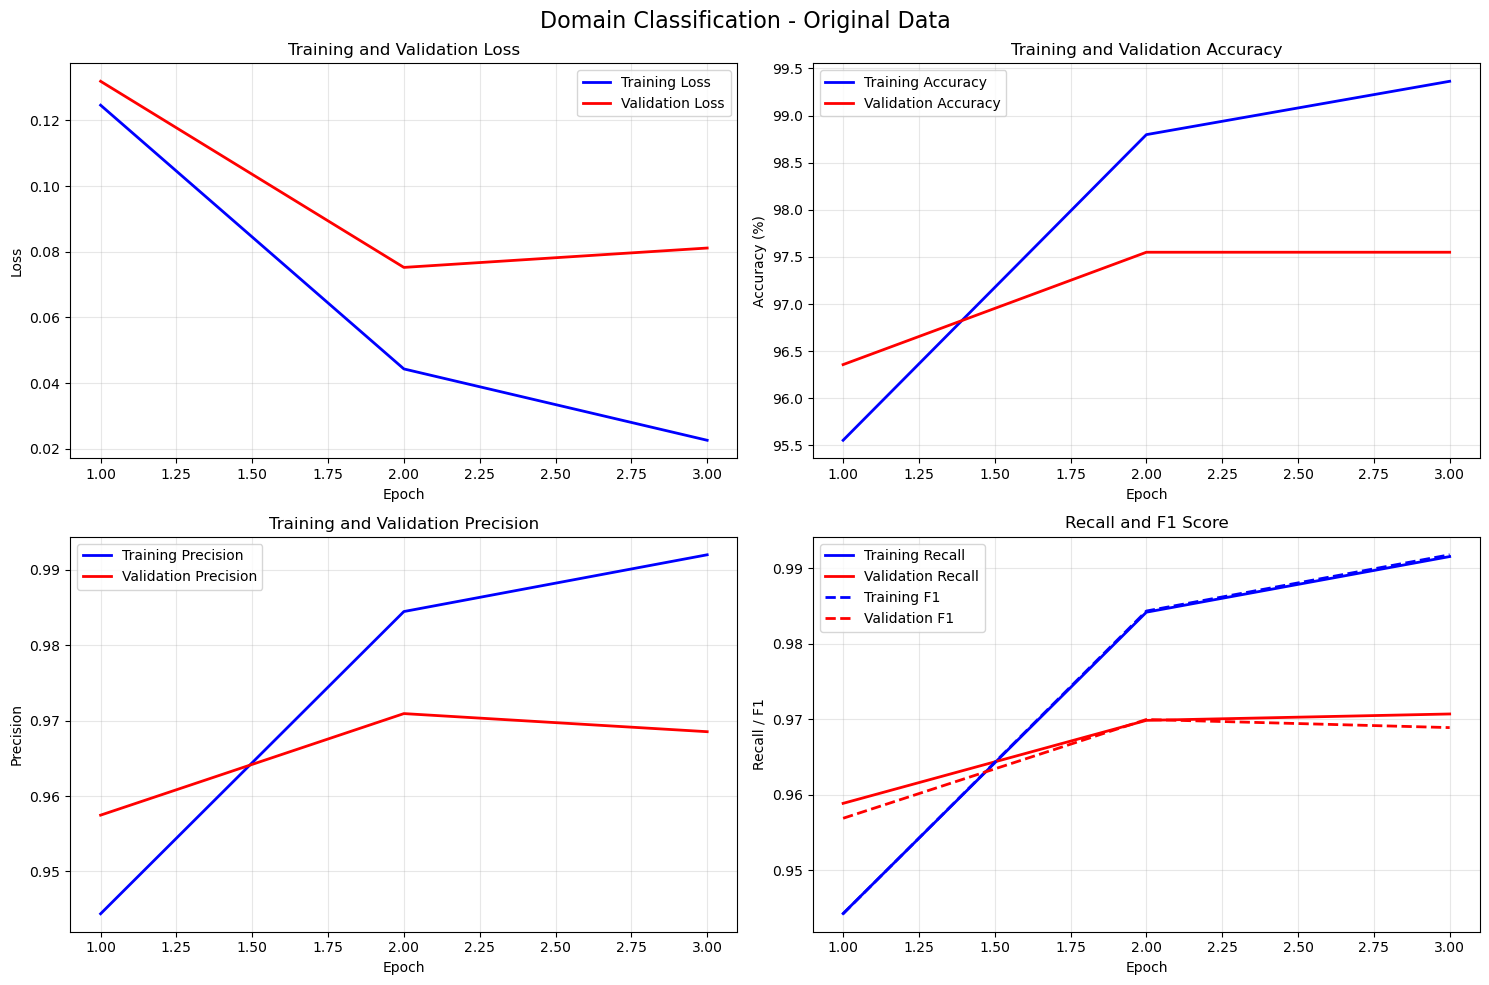

Final Training Accuracy: 99.36%
Final Validation Accuracy: 97.55%
Best Validation Accuracy: 97.55%
Final Training Precision: 0.99, Recall: 0.99, F1: 0.99
Final Validation Precision: 0.97, Recall: 0.97, F1: 0.97


'original/classification_results\\Domain_Classification___Original_Data_training_curves.png'

In [ ]:
# Plot training curves
plot_training_curves(results, "Domain Classification - Original Data", save_dir=f"{transformation}/classification_results")

In [ ]:
# Detailed evaluation of the trained model
print("📊 DETAILED EVALUATION")
eval_results = detailed_evaluation(model, og_validation_loaders['data'], device)

📊 DETAILED EVALUATION

Domain-wise Classification Results:
art_painting   :  91.32% ( 284/ 311)
cartoon        :  97.75% ( 347/ 355)
photo          :  99.21% ( 251/ 253)
sketch         : 100.00% ( 591/ 591)
--------------------------------------------------
Overall        :  97.55% (1473/1510)

Classification Summary:
art_painting   : Classified:  284, Unclassified:   27
cartoon        : Classified:  347, Unclassified:    8
photo          : Classified:  251, Unclassified:    2
sketch         : Classified:  591, Unclassified:    0

Domain-wise Classification Results:
art_painting   :  91.32% ( 284/ 311)
cartoon        :  97.75% ( 347/ 355)
photo          :  99.21% ( 251/ 253)
sketch         : 100.00% ( 591/ 591)
--------------------------------------------------
Overall        :  97.55% (1473/1510)

Classification Summary:
art_painting   : Classified:  284, Unclassified:   27
cartoon        : Classified:  347, Unclassified:    8
photo          : Classified:  251, Unclassified:    2
sket

In [ ]:
# Extract classified and unclassified dictionaries
classified = eval_results['classified']
unclassified = eval_results['unclassified']

# Print sample paths for verification
print("\n🗂️ CLASSIFIED/UNCLASSIFIED BREAKDOWN")
print("=" * 60)
for domain in classified.keys():
    print(f"\nDomain: {domain}")
    print(f"  Classified: {len(classified[domain])} images")
    print(f"  Unclassified: {len(unclassified[domain])} images")
    
    # Show sample paths
    if len(classified[domain]) > 0:
        print(f"  Sample classified paths:")
        for i, path in enumerate(classified[domain][:3]):  # Show first 3
            print(f"    {i+1}. {path}")
        if len(classified[domain]) > 3:
            print(f"    ... and {len(classified[domain])-3} more")
    
    if len(unclassified[domain]) > 0:
        print(f"  Sample unclassified paths:")
        for i, path in enumerate(unclassified[domain][:3]):  # Show first 3
            print(f"    {i+1}. {path}")
        if len(unclassified[domain]) > 3:
            print(f"    ... and {len(unclassified[domain])-3} more")

# Optional: Save to files for further analysis
base_dir = f"{transformation}/classification_results"

# Save classified images
with open(f'{base_dir}/classified_images.json', 'w') as f:
    json.dump(classified, f, indent=2)

# Save unclassified images
with open(f'{base_dir}/unclassified_images.json', 'w') as f:
    json.dump(unclassified, f, indent=2)

print("\n💾 Saved classified and unclassified image paths to JSON files:")
print("   - classified_images.json")
print("   - unclassified_images.json")


🗂️ CLASSIFIED/UNCLASSIFIED BREAKDOWN

Domain: art_painting
  Classified: 284 images
  Unclassified: 27 images
  Sample classified paths:
    1. e:\NEW PROJECT\DG with Continual Learning\DG with Continual Learning\Code\PACS\kfold\photo\guitar\n03467517_7007.jpg
    2. e:\NEW PROJECT\DG with Continual Learning\DG with Continual Learning\Code\PACS\kfold\sketch\guitar\n03467517_22785-2.png
    3. e:\NEW PROJECT\DG with Continual Learning\DG with Continual Learning\Code\PACS\kfold\cartoon\elephant\pic_504.jpg
    ... and 281 more
  Sample unclassified paths:
    1. e:\NEW PROJECT\DG with Continual Learning\DG with Continual Learning\Code\PACS\kfold\sketch\giraffe\n02439033_9398-4.png
    2. e:\NEW PROJECT\DG with Continual Learning\DG with Continual Learning\Code\PACS\kfold\sketch\horse\n02374451_6207-3.png
    3. e:\NEW PROJECT\DG with Continual Learning\DG with Continual Learning\Code\PACS\kfold\cartoon\horse\pic_327.jpg
    ... and 24 more

Domain: cartoon
  Classified: 347 images
  Unc

In [ ]:
def create_visualization_folders(classified, unclassified, output_dir='classification_results'):
    """
    Create folder structure to visualize classification results
    """
    
    # Create main output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Create subdirectories
    classified_dir = os.path.join(output_dir, 'classified')
    unclassified_dir = os.path.join(output_dir, 'unclassified')
    
    os.makedirs(classified_dir, exist_ok=True)
    os.makedirs(unclassified_dir, exist_ok=True)
    
    # Copy classified images
    print(f"Creating visualization folders in: {output_dir}")
    print("Copying classified images...")
    
    for domain, paths in classified.items():
        domain_dir = os.path.join(classified_dir, domain)
        os.makedirs(domain_dir, exist_ok=True)
        
        for i, img_path in enumerate(paths):
            if os.path.exists(img_path):
                filename = f"{i+1:04d}_{os.path.basename(img_path)}"
                dest_path = os.path.join(domain_dir, filename)
                shutil.copy2(img_path, dest_path)
        
        print(f"  {domain}: {len(paths)} images copied")
    
    # Copy unclassified images
    print("Copying unclassified images...")
    
    for domain, paths in unclassified.items():
        domain_dir = os.path.join(unclassified_dir, domain)
        os.makedirs(domain_dir, exist_ok=True)
        
        for i, img_path in enumerate(paths):
            if os.path.exists(img_path):
                filename = f"{i+1:04d}_{os.path.basename(img_path)}"
                dest_path = os.path.join(domain_dir, filename)
                shutil.copy2(img_path, dest_path)
        
        print(f"  {domain}: {len(paths)} images copied")
    
    print(f"\n✅ Visualization folders created successfully!")
    print(f"📁 Check the '{output_dir}' folder to see the results.")
    
    return output_dir

# Uncomment the line below to create visualization folders
output_dir = f"{transformation}/visualization_results"

create_visualization_folders(classified, unclassified, output_dir=output_dir)

Creating visualization folders in: original/visualization_results
Copying classified images...
  art_painting: 284 images copied
  art_painting: 284 images copied
  cartoon: 347 images copied
  cartoon: 347 images copied
  photo: 251 images copied
  photo: 251 images copied
  sketch: 591 images copied
Copying unclassified images...
  art_painting: 27 images copied
  cartoon: 8 images copied
  photo: 2 images copied
  sketch: 0 images copied

✅ Visualization folders created successfully!
📁 Check the 'original/visualization_results' folder to see the results.
  sketch: 591 images copied
Copying unclassified images...
  art_painting: 27 images copied
  cartoon: 8 images copied
  photo: 2 images copied
  sketch: 0 images copied

✅ Visualization folders created successfully!
📁 Check the 'original/visualization_results' folder to see the results.


'original/visualization_results'

In [ ]:
# Save the trained model
model_save_path = f'{transformation}/domain_classifier_resnet18.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'domain_to_idx': og_train_datasets['data'].domain_to_idx,
    'num_domains': num_domains,
    'results': results,
    'eval_results': eval_results
}, model_save_path)

print(f"✅ Model saved to: {model_save_path}")
print(f"Best validation accuracy achieved: {results['best_val_acc']:.2f}%")

✅ Model saved to: original/domain_classifier_resnet18.pth
Best validation accuracy achieved: 97.55%


## Optional: Training with Augmented Data

You can also train with your semantic transforms for potentially better domain generalization. Uncomment and run the cells below to compare performance.

In [ ]:
# # Example: Training with one of your semantic transforms
# # Uncomment to train with augmented data for comparison

# # Choose a transform (you can experiment with different ones)
# transform_name = list(train_loaders.keys())[0]  # Pick first transform
# print(f"Training with transform: {transform_name}")

# # Reset model for fair comparison
# augmented_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# augmented_model.fc = nn.Linear(augmented_model.fc.in_features, num_domains)
# augmented_model = augmented_model.to(device)

# augmented_optimizer = optim.Adam(augmented_model.parameters(), lr=1e-4)

# # Train with augmented data
# augmented_results = train_domain_classifier(
#     model=augmented_model,
#     train_loader=train_loaders[transform_name],
#     val_loader=validation_loaders[transform_name],
#     criterion=criterion,
#     optimizer=augmented_optimizer,
#     device=device,
#     num_epochs=30
# )

# # Plot comparison
# plot_training_curves(augmented_results, f"Domain Classification - {transform_name}")

# # Evaluate augmented model
# print("📊 AUGMENTED MODEL EVALUATION")
# augmented_eval = detailed_evaluation(augmented_model, validation_loaders[transform_name], device)